# Finite Markov Chains


## Topics

- Definitions
- Simulation
- Marginal Distributions
- Irreducibility and Aperiodicity
- Stationary Distributions
- Ergodicity
- Computing Expectations



## Overview

Markov chains are one of the most useful classes of stochastic processes, being

- simple, flexible and supported by many elegant theoretical results  
- central to quantitative modeling 

In this lecture, we review some of the theory of Markov chains.

We will also introduce some of the routines for working with Markov chains available in [QuantEcon.py](https://quantecon.org/quantecon-py/).

In [1]:
!pip install quantecon

Let’s start with some standard imports:

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

## Definitions

We recall some elementary definitions.


### Stochastic Matrices


A **stochastic matrix** (or **Markov matrix**)  is an $ n \times n $ square matrix $ P $
such that

1. each element of $ P $ is nonnegative, and  
1. each row of $ P $ sums to one  


Each row of $ P $ can be regarded as a probability mass function over $ n $ possible outcomes.

It is simple to check that if $ P $ is a stochastic matrix, then so is the $ k $-th power $ P^k $ for all $ k \in \mathbb N $.


### Markov Chains


There is a close connection between stochastic matrices and Markov chains.

To begin, let $ S $ be a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $.

We call $ S $ the **state space**.

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**.

This means that, for any date $ t $ and any state $ y \in S $,


$$
    \mathbb P \{ X_{t+1} = y  \,|\, X_t \}
    = \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \} 
$$

In other words, knowing the current state is enough to know probabilities for future states.

In particular, the dynamics of a Markov chain are fully determined by the set of values

$$
    P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
    \qquad (x, y \in S) 
$$

We can view $ P $ as a stochastic matrix where

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$

Going the other way, if we take a stochastic matrix $ P $, we can generate a Markov
chain $ \{X_t\} $ as follows:

- draw $ X_0 $ from a marginal distribution $ \psi $  
- for each $ t = 0, 1, \ldots $, draw $ X_{t+1} $ from $ P(X_t,\cdot) $  



### Example 1

Consider a worker who, at any given time $ t $, is either unemployed (state 0) or employed (state 1).

Suppose that, over a one month period,

1. An unemployed worker finds a job with probability $ \alpha \in (0, 1) $.  
1. An employed worker loses her job and becomes unemployed with probability $ \beta \in (0, 1) $.  


In terms of a Markov model, we have

- $ S = \{ 0, 1\} $  
- $ P(0, 1) = \alpha $ and $ P(1, 0) = \beta $  


We can write out the transition probabilities in matrix form as

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta      & 1 - \beta
\end{array}
  \right) 
$$

Once we have the values $ \alpha $ and $ \beta $, we can address a range of questions, such as

- What is the average duration of unemployment?  
- Over the long-run, what fraction of time does a worker find herself unemployed?  

We'll see how to do this below.



### Example 2

From  US unemployment data, James Hamilton estimated the stochastic matrix

$$
P =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

where

- the frequency is monthly  
- the first state represents “normal growth”  
- the second state represents “mild recession”  
- the third state represents “severe recession”  

For example, the matrix tells us that when the state is normal growth, the state will again be normal growth next month with probability 0.97.

In general, large values on the main diagonal indicate persistence in $ \{ X_t \} $.

This Markov process can also be represented as a directed graph, with edges labeled by transition probabilities

![https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png)

  

## Simulation

One natural way to study Markov chains is to simulate them.

(To approximate the probability of event $ E $, we can simulate many times and count the fraction of times that $ E $ occurs).

Let's start by writing our own.

(Later we'll use routines in [QuantEcon.py](http://quantecon.org/quantecon-py).)

In these exercises, we’ll take the state space to be $ S = 0,\ldots, n-1 $.



### Rolling Our Own

To simulate a Markov chain, we need its stochastic matrix $ P $ and a marginal probability distribution $ \psi $  from which to  draw a realization of $ X_0 $.

The Markov chain is then constructed as discussed above.  To repeat:

1. At time $ t=0 $, draw a realization of  $ X_0 $  from $ \psi $.  
1. At each subsequent time $ t $, draw a realization of the new state $ X_{t+1} $ from $ P(X_t, \cdot) $.  


To implement this simulation procedure, we need a method for generating draws from a discrete distribution.

For this task, we’ll use `random.draw` from [QuantEcon](http://quantecon.org/quantecon-py), which is accelerated by Numba and works as follows:

In [3]:
ψ = (0.3, 0.7)           # Probabilities over {0, 1}
cdf = np.cumsum(ψ)       # Convert into cummulative distribution
qe.random.draw(cdf, 5)   # Generate 5 independent draws from ψ

array([1, 1, 1, 0, 1])

We’ll write our code as a function that accepts the following three arguments

- A stochastic matrix `P`  
- An initial state `init`  
- A positive integer `sample_size` representing the length of the time series the function should return

In [4]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):
    """
    Generate a sample path of a finite state Markov chain with transition matrix
    P and initial distribution ψ_0.


    If ψ_0 is set to None then the initial draw will be uniform over the states.

    """

    # Set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # draw initial state, defaulting to 0
    if ψ_0 is None:
        X_0 = 0
    else:
        ψ_0 = np.cumsum(ψ_0)
        X_0 = qe.random.draw(ψ_0)

    # Convert each row of P into a cdf
    P = np.cumsum(P, axis=1)

    # Simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P[X[t], :])

    return X

Let’s see how it works using the small matrix

In [5]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

As we’ll see later, for a long series drawn from `P`, the fraction of the sample that takes value 0 should be about 0.25.

The following code illustrates this

In [6]:
X = mc_sample_path(P, ψ_0=(0.1, 0.9), sample_size=100_000)
np.mean(X == 0)

0.2523

Here we chose a particular initial condition but the result holds regardless of the initial distribution.

You can try changing the initial distribution to confirm this.


### Using QuantEcon’s Routines

[QuantEcon.py](http://quantecon.org/quantecon-py) has routines for handling Markov chains, including simulation.

Here’s an illustration using the same P as the preceding example

In [7]:
from quantecon import MarkovChain

mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.25032

The [QuantEcon.py](http://quantecon.org/quantecon-py) routine is [JIT compiled](https://python-programming.quantecon.org/numba.html#numba-link) and hence faster.

In [8]:
%time mc_sample_path(P, sample_size=1_000_000) # Our homemade version

CPU times: user 1.19 s, sys: 432 µs, total: 1.19 s
Wall time: 1.19 s


array([0, 1, 0, ..., 1, 1, 1])

In [9]:
%time mc.simulate(ts_length=1_000_000)         # QE version

CPU times: user 18.4 ms, sys: 3.97 ms, total: 22.3 ms
Wall time: 21.2 ms


array([1, 1, 1, ..., 1, 1, 0])

**Exercise**

Try producing a JIT compiled version of our homemade function `mc_sample_path`.

Hints:

- You might need to replace `int` with `numba.int32` or similar
- You can simplify by replacing `ψ_0=None` with `ψ_0`

How does the timing compare to the original and the QuantEcon routine?

In [10]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

Here's one solution.

In [26]:
import numba

@numba.jit
def mc_sample_path_fast(P, ψ_0, sample_size=1_000):

    # Set up
    P = np.asarray(P)
    ψ_0 = np.asarray(ψ_0)
    X = np.empty(sample_size, dtype=numba.int32)

    # draw initial state
    ψ_0 = np.cumsum(ψ_0)
    X_0 = qe.random.draw(ψ_0)

    # Convert each row of P into a cdf
    P_cdf = np.empty_like(P)
    for i in range(len(P)):
        P_cdf[i, :] = np.cumsum(P[i, :])
    P = P_cdf
    
    # Simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P[X[t], :])

    return X

ψ_0 = (1, 0)
%time mc_sample_path_fast(P, ψ_0, sample_size=1_000_000)
%time mc_sample_path_fast(P, ψ_0, sample_size=1_000_000)

CPU times: user 304 ms, sys: 4.15 ms, total: 308 ms
Wall time: 307 ms
CPU times: user 39.2 ms, sys: 0 ns, total: 39.2 ms
Wall time: 39.3 ms


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Incidentally, we can also hold the stochastic matrix as state in a jitted function as follows.

In [32]:
def mc_sample_path_factory(P, ψ_0):

    # Set up
    P = np.asarray(P)
    ψ_0 = np.asarray(ψ_0)

    # draw initial state
    ψ_0 = np.cumsum(ψ_0)

    # Convert each row of P into a cdf
    P_cdf = np.empty_like(P)
    for i in range(len(P)):
        P_cdf[i, :] = np.cumsum(P[i, :])
    P = P_cdf

    @numba.jit
    def mc_sample_path_closure(sample_size=1_000):
        X_0 = qe.random.draw(ψ_0)
        X = np.empty(sample_size, dtype=numba.int32)
        # Simulate
        X[0] = X_0
        for t in range(sample_size - 1):
            X[t+1] = qe.random.draw(P[X[t], :])
        return X

    return mc_sample_path_closure

mc_sample_path_closure = mc_sample_path_factory(P, ψ_0)

%time mc_sample_path_closure(sample_size=1_000_000)
%time mc_sample_path_closure(sample_size=1_000_000)

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 150 ms
CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 28.3 ms


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

## Marginal Distributions
Suppose that

1. $ \{X_t\} $ is a Markov chain with stochastic matrix $ P $  
1. the marginal distribution of $ X_t $ is known to be $ \psi_t $  


What then is the marginal distribution of $ X_{t+1} $, or, more generally, of $ X_{t+m} $?

To answer this, we let $ \psi_t $ be the marginal distribution of $ X_t $ for $ t = 0, 1, 2, \ldots $.

Our first aim is to find $ \psi_{t + 1} $ given $ \psi_t $ and $ P $.

To begin, pick any $ y  \in S $.

Using the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability), we can decompose the probability that $ X_{t+1} = y $ as follows:

$$
\mathbb P \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb P \{ X_t = x \}
$$

In words, to get the probability of being at $ y $ tomorrow, we account for
all  ways this can happen and sum their probabilities.

Rewriting this statement in terms of  marginal and conditional probabilities gives

$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

There are $ n $ such equations, one for each $ y \in S $.

If we think of $ \psi_{t+1} $ and $ \psi_t $ as *row vectors*, these $ n $ equations are summarized by the matrix expression


$$
\psi_{t+1} = \psi_t P 
$$

Thus, to move a marginal distribution forward one unit of time, we postmultiply by $ P $.

By postmultiplying $ m $ times, we move a marginal distribution forward $ m $ steps into the future.

That is, $ \psi_{t+m} = \psi_t P^m $ where $ P^m $ is the $ m $-th power of $ P $.

As a special case, we see that if $ \psi_0 $ is the initial distribution from
which $ X_0 $ is drawn, then $ \psi_0 P^m $ is the distribution of
$ X_m $.


More generally,

$$
    X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m 
$$


### Multiple Step Transition Probabilities

We know that the probability of transitioning from $ x $ to $ y $ in
one step is $ P(x,y) $.

In addition, the probability of transitioning from $ x $ to $ y $ in $ m $
steps is $ P^m(x,y) $, the $ (x,y) $-th element of the $ m $-th power of $ P $.

In particular

$$
    \mathbb P \{X_{t+m} = y \,|\, X_t = x \} = P^m(x, y) = (x, y) \text{-th element of } P^m
$$





### Example: Probability of Recession

Recall Hamilton's stochastic matrix $ P $ for recession and growth considered above

Suppose that the current state is unknown — perhaps statistics are available only  at the *end* of the current month.

We guess that the probability that the economy is in state $ x $ is $ \psi(x) $.

The probability of being in recession (either mild or severe) in 6 months time is given by the inner product

$$
\psi P^6
\cdot
\left(
  \begin{array}{c}
     0 \\
     1 \\
     1
  \end{array}
\right)
$$



### Example 2: Cross-Sectional Distributions

The marginal distributions we have been studying can be viewed either as
probabilities or as cross-sectional frequencies.

To illustrate, recall our model of employment/unemployment dynamics.

Consider a large population of workers, each of whose lifetime experience is described by the specified dynamics, with each worker’s
outcomes being realizations of processes that are statistically independent of all other workers’ processes.

Let $ \psi $ be the current *cross-sectional* distribution over $ \{ 0, 1 \} $.

The cross-sectional distribution records fractions of workers employed and unemployed at a given moment.

- For example, $ \psi(0) $ is the unemployment rate.  

What will the cross-sectional distribution be in 10 periods hence?

The answer is $ \psi P^{10} $, where $ P $ is the stochastic matrix for the model.

This is because each worker’s state evolves according to $ P $, so
$ \psi P^{10} $ is a marginal distibution  for a single randomly selected
worker.

But when the sample is large, outcomes and probabilities are roughly equal (by an application of the Law
of Large Numbers).

So for a very large (tending to infinite) population,
$ \psi P^{10} $ also represents  fractions of workers in
each state.

This is exactly the cross-sectional distribution.


## Irreducibility and Aperiodicity


Irreducibility and aperiodicity are central concepts of modern Markov chain theory.


### Irreducibility

Let $ P $ be a fixed stochastic matrix.

Two states $ x $ and $ y $ are said to **communicate** with each other if
there exist positive integers $ j $ and $ k $ such that

$$
    P^j(x, y) > 0
    \quad \text{and} \quad
    P^k(y, x) > 0
$$

This means that

- state $ x $ can eventually be reached  from state $ y $, and  
- state $ y $ can eventually  be reached from state $ x $  


The stochastic matrix $ P $ is called **irreducible** if all states
communicate; that is, if $ x $ and $ y $ communicate for all
$ (x, y) $ in $ S \times S $.

For example, consider the following transition probabilities for wealth of a fictitious set of
households

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png)

  
We can translate this into a stochastic matrix, putting zeros where
there’s no edge between nodes

$$
P :=
\left(
  \begin{array}{ccc}
     0.9 & 0.1 & 0 \\
     0.4 & 0.4 & 0.2 \\
     0.1 & 0.1 & 0.8
  \end{array}
\right)
$$

It’s clear from the graph that this stochastic matrix is irreducible: we can  eventually
reach any state from any other state.

We can also test this using [QuantEcon.py](http://quantecon.org/quantecon-py)’s MarkovChain class

In [16]:
P = [[0.9, 0.1, 0.0],
     [0.4, 0.4, 0.2],
     [0.1, 0.1, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

Here’s a more pessimistic scenario in which  poor people remain poor forever

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility2.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility2.png)

  
This stochastic matrix is not irreducible, since, for example, rich is not accessible from poor.

Let’s confirm this

In [17]:
P = [[1.0, 0.0, 0.0],
     [0.1, 0.8, 0.1],
     [0.0, 0.2, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

False

Irreducibility is important for understanding long run outcomes.

For example, poverty is a life sentence in the second graph but not the first.


### Aperiodicity

Loosely speaking, a Markov chain is called **periodic** if it cycles in a predictable way, and **aperiodic** otherwise.

Here’s a trivial example with three states

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity1.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity1.png)

  
The chain cycles with period 3:

In [18]:
P = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

mc = qe.MarkovChain(P)
mc.period

3

More formally, the **period** of a state $ x $ is the largest common divisor
of a set of integers

$$
    D(x) := \{j \geq 1 : P^j(x, x) > 0\}
$$

In the last example, $ D(x) = \{3, 6, 9, \ldots\} $ for every state $ x $, so the period is 3.

A stochastic matrix is called **aperiodic** if the period of every state is 1, and **periodic** otherwise.

For example, the stochastic matrix associated with the transition probabilities below is periodic because, for example, state $ a $ has period 2

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png)

We can confirm that the stochastic matrix is periodic with the following code

In [19]:
P = [[0.0, 1.0, 0.0, 0.0],
     [0.5, 0.0, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 1.0, 0.0]]

mc = qe.MarkovChain(P)
mc.period

2

In [20]:
mc.is_aperiodic

False

## Stationary Distributions


We know that we can shift a marginal distribution forward one unit of time via postmultiplication by $ P $.

Some distributions are invariant under this updating process — for example,

In [21]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

Such distributions are called **stationary** or **invariant**.


Formally, a marginal distribution $ \psi^* $ on $ S $ is called **stationary** for $ P $ if $ \psi^* = \psi^* P $.

From this equality, we immediately get $ \psi^* = \psi^* P^t $ for all $ t $.

This tells us an important fact: If the distribution of $ X_0 $ is a stationary distribution, then $ X_t $ will have this same distribution for all $ t $.

Hence stationary distributions have a natural interpretation as **stochastic steady states** — we’ll discuss this more soon.

Mathematically, a stationary distribution is a fixed point of $ P $ when $ P $ is thought of as the map $ \psi \mapsto \psi P $ from (row) vectors to (row) vectors.

**Theorem.** Every stochastic matrix $ P $ has at least one stationary distribution.

Proof:  This follows directly from the Perron-Frobenius theorem -- alternatively, see [EDTC](https://johnstachurski.net/edtc.html), theorem 4.3.5.

There can be many stationary distributions corresponding to a given stochastic matrix $ P $.

- For example, if $ P $ is the identity matrix, then all marginal distributions are stationary.  

To get uniqueness an invariant distribution, the transition matrix $ P $ must have the property that no nontrivial subsets of
the state space are **infinitely persistent**.

A subset of the state space is infinitely persistent if other parts of the
state space cannot be accessed from it.

Thus, infinite persistence of a non-trivial subset is the opposite of irreducibility.

This gives some intuition for the following fundamental theorem.


**Theorem.** If $ P $ is both aperiodic and irreducible, then

1. $ P $ has exactly one stationary distribution $ \psi^* $.  
1. For any initial marginal distribution $ \psi_0 $, we have $ \| \psi_0 P^t - \psi^* \| \to 0 $ as $ t \to \infty $.  


For a proof, see, for example, theorem 5.2 of [[Haggstrom02](https://python.quantecon.org/zreferences.html#id135)].

(Note that part 1 of the theorem only requires  irreducibility, whereas part 2 requires both irreducibility and aperiodicity)

A stochastic matrix that satisfies the conditions of the theorem is sometimes called **uniformly ergodic**.

A sufficient condition for aperiodicity and irreducibility is that every element of $ P $ is strictly positive.



### Example

Recall our model of the employment/unemployment dynamics.

Assuming $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, the uniform ergodicity condition is satisfied.

Let $ \psi^* = (p, 1-p) $ be the stationary distribution, so that $ p $ corresponds to unemployment (state 0).

Using $ \psi^* = \psi^* P $ and a bit of algebra yields

$$
    p = \frac{\beta}{\alpha + \beta}
$$

This is, in some sense, a steady state probability of unemployment — more about the  interpretation of this below.

Not surprisingly it tends to zero as $ \beta \to 0 $, and to one as $ \alpha \to 0 $.


### Calculating Stationary Distributions


As discussed above, a particular Markov matrix $ P $ can have many stationary distributions.

That is, there can be many row vectors $ \psi $ such that $ \psi = \psi P $.

In fact if $ P $ has two distinct stationary distributions $ \psi_1,
\psi_2 $ then it has infinitely many, since in this case, as you can verify,  for any $ \lambda \in [0, 1] $

$$
\psi_3 := \lambda \psi_1 + (1 - \lambda) \psi_2
$$

is a stationary distribution for $ P $.

If we restrict attention to the case in which only one stationary distribution exists, one way to  finding it is to solve the system


$$
    \psi (I_n - P) = 0
$$

for row vector $ \psi $, where $ I_n $ is the $ n \times n $ identity.

But the zero vector solves this system,  so we must proceed cautiously.

We want to impose the restriction that $ \psi $ is  a probability distribution.

There are various ways to do this.

One option is to regard the system as an eigenvector problem: a vector
$ \psi $ such that $ \psi = \psi P $ is a left eigenvector associated
with the unit eigenvalue $ \lambda = 1$.

A stable and sophisticated algorithm specialized for stochastic matrices is implemented in [QuantEcon.py](http://quantecon.org/quantecon-py).

This is the one we recommend:

In [22]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # Show all stationary distributions

array([[0.25, 0.75]])

### Convergence to Stationarity


Part 2 of the Markov chain convergence theorem given above tells us that, under
the stated conditions, the marginal distribution of $ X_t $ converges to the
stationary distribution regardless of the initial condition.

This adds considerable authority to our interpretation of $ \psi^* $ as a stochastic steady state.

The convergence in the theorem is illustrated in the next figure

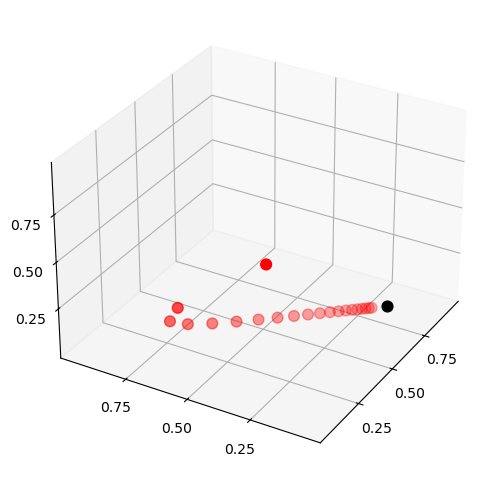

In [23]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
P = np.array(P)

ψ = (0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()

Here

- $ P $ is the stochastic matrix for recession and growth [considered above](#mc-eg2).  
- The highest red dot is an arbitrarily chosen initial marginal probability distribution  $ \psi $, represented as a vector in $ \mathbb R^3 $.  
- The other red dots are the marginal distributions $ \psi P^t $ for $ t = 1, 2, \ldots $.  
- The black dot is $ \psi^* $.  


You might like to try experimenting with different initial conditions.


## Ergodicity


Under irreducibility, yet another important result obtains: for all $ x \in S $,

$$
\frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = x\}  \to \psi^*(x)
    \quad \text{as } m \to \infty 
$$

Here

- $ \mathbf{1}\{X_t = x\} = 1 $ if $ X_t = x $ and zero otherwise  
- convergence is with probability one  
- the result does not depend on the marginal distribution  of $ X_0 $  

The convergence asserted above is a special case of a law of large numbers
result for Markov chains -- see, for example, [EDTC](http://johnstachurski.net/edtc.html),
section 4.3.4.

The result tells us that the fraction of time the chain spends at state $ x $ converges to $ \psi^*(x) $ as time goes to infinity.

This gives us another way to interpret the stationary distribution.


### Example

Recall our cross-sectional interpretation of the employment/unemployment model discussed above.

Assume that $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, so that irreducibility and aperiodicity both hold.

We saw that the stationary distribution is $ (p, 1-p) $, where

$$
    p = \frac{\beta}{\alpha + \beta}
$$

In the cross-sectional interpretation, this is the fraction of people unemployed.

In view of our latest (ergodicity) result, it is also the fraction of time that a single worker can expect to spend unemployed.

Thus, in the long-run, cross-sectional averages for a population and time-series averages for a given person coincide.

This is one aspect of the concept  of ergodicity.


## Computing Expectations


We sometimes want to  compute mathematical  expectations of functions of $ X_t $ of the form


$$
    \mathbb E [ h(X_t) ] 
$$

and conditional expectations such as

$$
    \mathbb E [ h(X_{t + k})  \mid X_t = x] 
$$

where

- $ \{X_t\} $ is a Markov chain generated by $ n \times n $ stochastic matrix $ P $  
- $ h $ is a given function, which, in terms of matrix
  algebra, we’ll think of as the column vector  


$$
    h
    = \left(
    \begin{array}{c}
        h(x_1) \\
        \vdots \\
        h(x_n)
    \end{array}
      \right)
$$

Computing the unconditional expectation  is easy.

We just sum over the marginal  distribution  of $ X_t $ to get

$$
\mathbb E [ h(X_t) ]
= \sum_{x \in S} (\psi P^t)(x) h(x)
$$

Here $ \psi $ is the distribution of $ X_0 $.

Since $ \psi $ and hence $ \psi P^t $ are row vectors, we can also
write this as

$$
\mathbb E [ h(X_t) ]
=  \psi P^t h
$$

For the conditional expectation we need to sum over the conditional distribution
of $ X_{t + k} $ given $ X_t = x $.

We already know that this is $ P^k(x, \cdot) $, so


$$
\mathbb E [ h(X_{t + k})  \mid X_t = x]
= (P^k h)(x) 
$$

The vector $ P^k h $ stores the conditional expectation $ \mathbb E [ h(X_{t + k})  \mid X_t = x] $ over all $ x $.


### Expectations of Geometric Sums

Sometimes we want to compute the mathematical expectation of a geometric sum, such as
$ \sum_t \beta^t h(X_t) $.

In view of the preceding discussion, this is

$$
\mathbb{E} [
        \sum_{j=0}^\infty \beta^j h(X_{t+j}) \mid X_t = x
    \Bigr]
= [(I - \beta P)^{-1} h](x)
$$

where

$$
(I - \beta P)^{-1}  = I + \beta P + \beta^2 P^2 + \cdots
$$



## More Exercises


## Exercise 24.1

According to the discussion [above](#mc-eg1-2), if a worker’s employment dynamics obey the stochastic matrix

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

with $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, then, in the long-run, the fraction
of time spent unemployed will be

$$
p := \frac{\beta}{\alpha + \beta}
$$

In other words, if $ \{X_t\} $ represents the Markov chain for
employment, then $ \bar X_m \to p $ as $ m \to \infty $, where

$$
\bar X_m := \frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = 0\}
$$

This exercise asks you to illustrate convergence by computing
$ \bar X_m $ for large $ m $ and checking that
it is close to $ p $.

You will see that this statement is true regardless of the choice of initial
condition or the values of $ \alpha, \beta $, provided both lie in
$ (0, 1) $.


## Solution 

We will address this exercise graphically.

The plots show the time series of $ \bar X_m - p $ for two initial
conditions.

As $ m $ gets large, both series converge to zero.

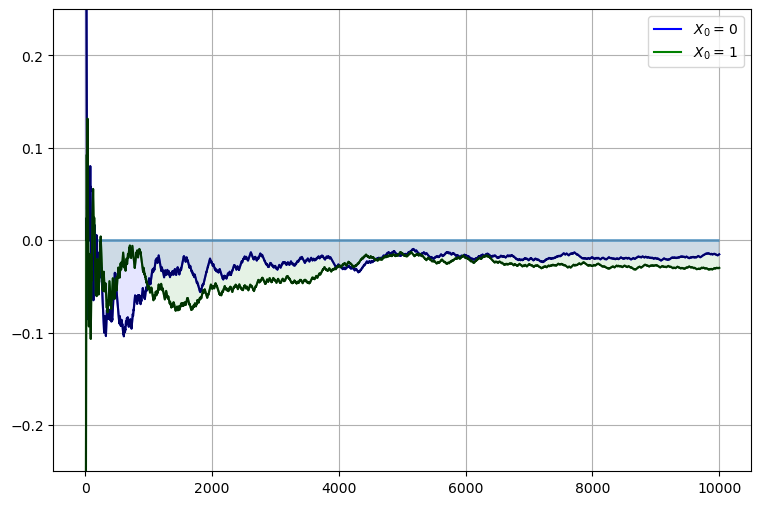

In [24]:
α = β = 0.1
N = 10000
p = β / (α + β)

P = ((1 - α,       α),               # Careful: P and p are distinct
     (    β,   1 - β))
mc = MarkovChain(P)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-0.25, 0.25)
ax.grid()
ax.hlines(0, 0, N, lw=2, alpha=0.6)   # Horizonal line at zero

for x0, col in ((0, 'blue'), (1, 'green')):
    # Generate time series for worker that starts at x0
    X = mc.simulate(N, init=x0)
    # Compute fraction of time spent unemployed, for each n
    X_bar = (X == 0).cumsum() / (1 + np.arange(N, dtype=float))
    # Plot
    ax.fill_between(range(N), np.zeros(N), X_bar - p, color=col, alpha=0.1)
    ax.plot(X_bar - p, color=col, label=f'$X_0 = \, {x0} $')
    # Overlay in black--make lines clearer
    ax.plot(X_bar - p, 'k-', alpha=0.6)

ax.legend(loc='upper right')
plt.show()